# Exploratory Data Analysis

Hypotheses:
- I expect tax value to be primarily driven by:
  - **square feet:** more sf will increase price values
  - **bed/bath number:** more beds and baths will increase tax values
  - **county:** Orange and LA county will have higher tax values than Ventura.  LA is expected to have wider range of values than Orange
    - NOTE: This would be a better driver if we had smaller geographic areas.

In [2]:
#Basics
import numpy as np
import pandas as pd
from itertools import combinations, product, permutations

#Stats
from scipy import stats

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind')

#My Modules
from wrangle import wrangle_zillow
import utils

#Ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
#Acquire Data
tr, te, val = wrangle_zillow()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
tr.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470497 entries, 1927605 to 674262
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   value       1470497 non-null  float64
 1   county      1470497 non-null  object 
 2   bed         1470497 non-null  int64  
 3   bath        1470497 non-null  float64
 4   sf          1470497 non-null  float64
 5   yearbuilt   1470497 non-null  int64  
 6   Orange_CA   1470497 non-null  uint8  
 7   Ventura_CA  1470497 non-null  uint8  
dtypes: float64(3), int64(2), object(1), uint8(2)
memory usage: 81.3+ MB


In [5]:
tr_eda = tr.iloc[:,0:6]
tr_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470497 entries, 1927605 to 674262
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   value      1470497 non-null  float64
 1   county     1470497 non-null  object 
 2   bed        1470497 non-null  int64  
 3   bath       1470497 non-null  float64
 4   sf         1470497 non-null  float64
 5   yearbuilt  1470497 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 78.5+ MB


## Univariate
- descriptive stats
- frequencies/histograms

#### Categorical

In [6]:
tr_eda.county.value_counts()

LosAngeles_CA    977964
Orange_CA        379469
Ventura_CA       113064
Name: county, dtype: int64

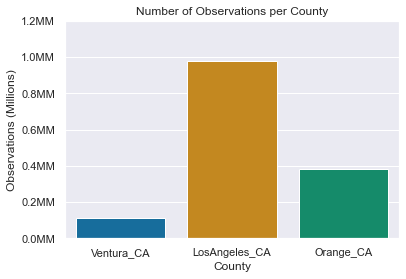

In [7]:
ax = sns.countplot(x=tr_eda.county);
ylabels = ['{:.1f}'.format(y) + 'MM' for y in ax.get_yticks()/1000000];
ax.set(ylabel='Observations (Millions)',xlabel='County',title='Number of Observations per County',yticks=ax.get_yticks(),yticklabels=ylabels);

#### Continuous

In [8]:
tr_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
value,1470497.0,400280.236681,315998.518132,22.0,186393.0,322984.0,517941.0,1999908.0
bed,1470497.0,3.280135,0.909234,0.0,3.0,3.0,4.0,9.0
bath,1470497.0,2.191455,0.897136,0.0,2.0,2.0,3.0,9.5
sf,1470497.0,1805.073541,803.566653,120.0,1251.0,1609.0,2166.0,9398.0
yearbuilt,1470497.0,1960.676866,21.883110,1801.0,1949.0,1958.0,1975.0,2016.0


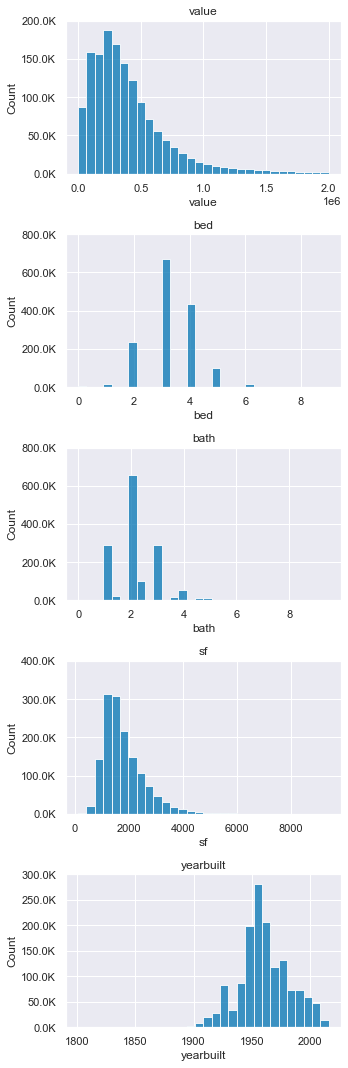

In [9]:
plt.figure(figsize=(5,15))
ct=0
for c in tr_eda.select_dtypes(exclude='object').columns:
    ct+=1
    plt.subplot(5,1,ct)
    ax = sns.histplot(data=tr_eda[c], bins=30)
    ax.set_title(c)
    utils.yticks_k(ax)

plt.tight_layout()

### Univariate Summary:
- County has ~3x the observations in LA than Orange, and Orange has ~3x the observations than Ventura.
- Value is skewed right, few values past 1 million
- Both beds and baths are normalish
- SF is skewed right, very few values past 4k
- Year built is skewed left, very few values before 1900

## Bivariate
- interactions with target
- hypothesis testing

#### Categorical

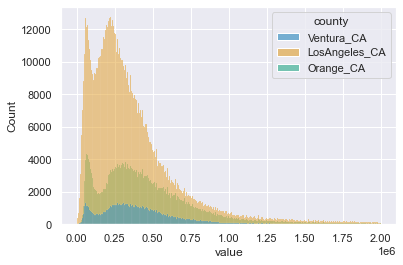

In [10]:
ax = sns.histplot(data=tr_eda, x='value',hue='county')

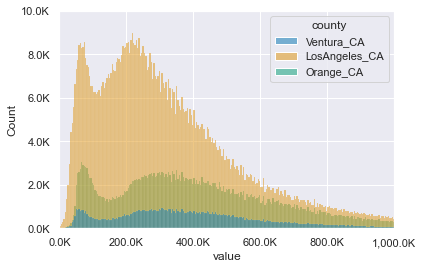

In [11]:
#Let's zoom in on the left-hand side
ax = sns.histplot(data=tr_eda, x='value',hue='county',bins=500)
ax.set_xlim((0,1_000_000));
utils.yticks_k(ax)
utils.xticks_k(ax)

In [49]:
def plot_cat_and_continuous(df,**kwargs):
    '''
    Takes dataframe and plots all categorical variables vs all continuous variables. \
    Subset of categorical columns and continuous columns can be passed.  If not specified,\
    Assumes all objects and boolean columns to be categories and all numeric columns to be continuous
    **DOES NOT HANDLE DATETIMES**
    
    OUTPUTS: Charts
    RETURNS: None
    INPUTS:
      (R)            df: Pandas Dataframe containing categorical and continous columns
      (O)   sample_size: number of rows to use when plotting.  Default 50_000
      (O)      cat_cols: List of categorical columns to be plotted. Default: object and boolean dtypes
      (O)     cont_cols: List of continuous columns to be plotted. Default: numeric dtypes
    '''
    #pull out sample size
    ss = kwargs.get('sample_size',50_000) # Default 50k
    #If sample size is smaller than df rows, pull out a sample of the data
    if ss < df.shape[0]: df = df.sample(n=ss,random_state=88)

    #Get categorical and continuous features
    cats = kwargs.get('cat_cols',df.select_dtypes(include=['bool','object']))
    conts = kwargs.get('cont_cols',df.select_dtypes(include='number'))
    
    #create pairs
    pairs = product(cats,conts)
    
    #Loop over pairs to plot
    for pair in pairs:
        #Cats will be first in the pair
        cat= pair[0]
        cont= pair[1]
        #Plot 3 charts (1x3)
        fig, ax = plt.subplots(1,3,figsize=(12,4),sharey=True)
        fig.suptitle(f'{cont} vs. {cat}')
        
        #First Chart
        plt.subplot(1,3,1)
        sns.boxplot(data=df,x=cat,y=cont)
        #Format y axis
        if df[cont].max() > 1_000_000: utils.yticks_mm(ax[0])
        elif df[cont].max() > 2500: utils.yticks_k(ax[0])
        #Other Charts - shared y axis
        plt.subplot(1,3,2)
        sns.violinplot(data=df,x=cat,y=cont)
        plt.subplot(1,3,3)
        sns.stripplot(data=df,x=cat,y=cont)
        plt.tight_layout()
    
    return None

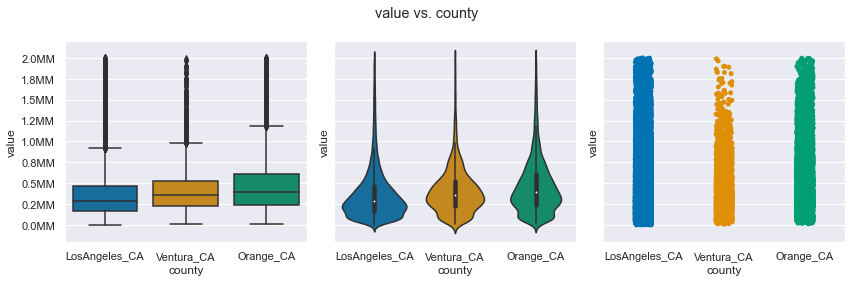

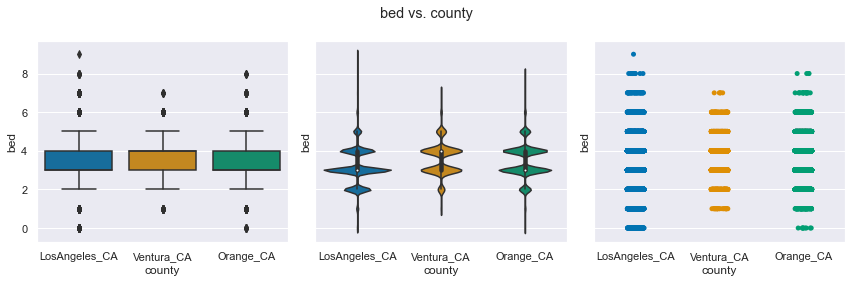

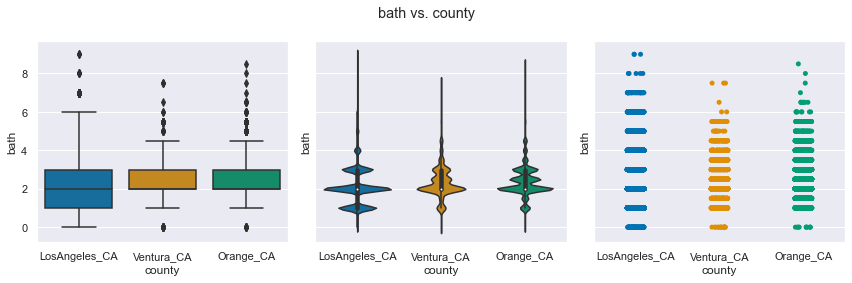

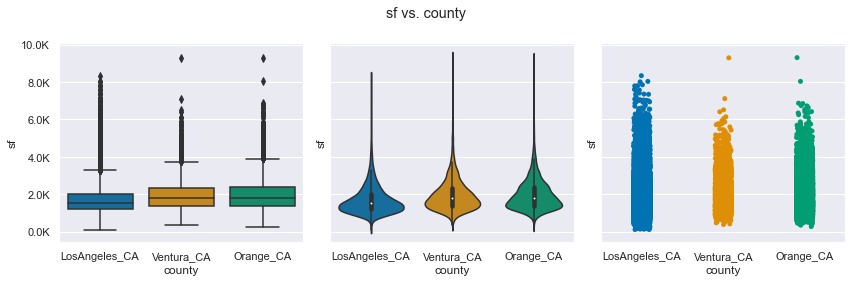

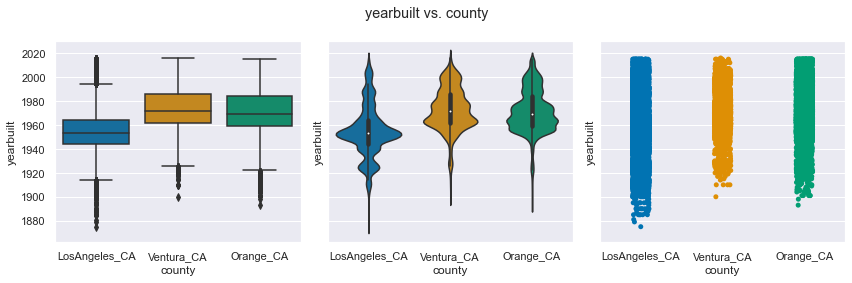

In [50]:
plot_cat_and_continuous(tr_eda)

#### Continuous

In [ ]:
def plot_variable_pairs(df,**kwargs):
    '''
    Creates combinations of numeric columns, then creates a scatterplot and regression line.\
    Do not include encoded columns when calling function.
    
    Outputs: Scatterplot with regression line
    Returns: None
    Inputs: 
     (R)          df: Dataframe containing multiple numeric columns.
     (O) sample_size: number of rows to use when plotting.  Default 50_000
    '''
    #only include numeric datatypes 
    #doesn't currently handle datetimes - would want it to plot that on X
    df = tr_eda.select_dtypes(include='number')

    #SCATTERPLOTS
    #pull out sample size
    ss = kwargs.get('sample_size',50_000) # Default 50k
    #If sample size is smaller than df rows, pull out a sample of the data
    if ss < df.shape[0]: df = df.sample(n=ss,random_state=88)

    #get combinations
    combos = combinations(df.columns,2)

    #Loop over combinations and plot
    for pair in combos:
        #Add a chart - lmplot generates facetgrid
        sns.lmplot(data=df,x=pair[0],y=pair[1],line_kws={'color':'red'})
        plt.title(f'{pair[1]} vs {pair[0]}')
        plt.show()
    
    return None


# TO DO:
- Review current state in EDA exercises
- Put functions into module >> make sure access to utils


### Bivariate Summary
- County: all counties show a dip b/w 100k and 200k.  No obvious disparities in value pattern
